In [12]:
# Cell 1: Import Libraries and Define Helper Functions

import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
import os
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

torch.set_printoptions(precision=2, linewidth=160)

# Helper functions

def adjacency_to_incidence(A, n_nodes, max_edges):
    """
    Converts an adjacency matrix A to an incidence matrix B.
    Pads the incidence matrix to have max_edges columns.
    """
    edges = []
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            if A[i, j] != 0:
                edges.append((i, j))
    n_edges = len(edges)
    B = torch.zeros(n_nodes, max_edges)
    for idx, (i, j) in enumerate(edges):
        B[i, idx] = 1
        B[j, idx] = -1
    return B, n_edges

def get_laplacian(B):
    # B is of shape [batch_size, n_nodes, n_edges]
    return torch.einsum('ijk,ilk->ijl', B, B)

def L_ev_loss(model, Z, inds=None, k=-1, visualize=False, t=None):
    """
    Loss function with visualization option
    Args:
        visualize: 是否可视化归一化过程
        t: 当前训练迭代次数（用于图标题）
    """
    n = Z.shape[1]
    d = Z.shape[2] - n - n
    assert inds is not None

    # Get Laplacian and compute eigendecomposition
    lap = Z[:, :, :n]
    eigenvals, target = torch.linalg.eigh(lap)
    target = target.real
    
    output = model(Z)
    predicted_ev = output[:, :, -k:]
    if inds is not None:
        predicted_ev = predicted_ev[:, :, inds]
        target = target[:, :, inds]

    # Store unnormalized versions
    predicted_unnorm = predicted_ev.clone()
    target_unnorm = target.clone()

    # Normalize
    predicted_ev = predicted_ev / predicted_ev.norm(p=2, dim=1)[:, None, :]
    target = target / target.norm(p=2, dim=1)[:, None, :]

    if visualize:
        plt.figure(figsize=(15, 3*len(inds)))
        for idx, ev_idx in enumerate(inds):
            # Plot predicted eigenvector
            plt.subplot(len(inds), 2, 2*idx + 1)
            plt.plot(predicted_unnorm[0, :, idx].cpu().detach(), 'b-', label='Before')
            plt.plot(predicted_ev[0, :, idx].cpu().detach(), 'r-', label='After')
            plt.title(f'Predicted EV{ev_idx+1} Normalization\nIter {t if t is not None else ""}')
            plt.grid(True)
            plt.legend()

            # Print statistics
            print(f"\nPredicted EV{ev_idx+1} statistics:")
            print("Before normalization:")
            print(f"  Range: [{predicted_unnorm[0,:,idx].min():.3f}, {predicted_unnorm[0,:,idx].max():.3f}]")
            print(f"  Mean: {predicted_unnorm[0,:,idx].mean():.3f}")
            print(f"  Norm: {predicted_unnorm[0,:,idx].norm():.3f}")
            print("After normalization:")
            print(f"  Range: [{predicted_ev[0,:,idx].min():.3f}, {predicted_ev[0,:,idx].max():.3f}]")
            print(f"  Mean: {predicted_ev[0,:,idx].mean():.3f}")
            print(f"  Norm: {predicted_ev[0,:,idx].norm():.3f}")

            # Plot target eigenvector
            plt.subplot(len(inds), 2, 2*idx + 2)
            plt.plot(target_unnorm[0, :, idx].cpu().detach(), 'b-', label='Before')
            plt.plot(target[0, :, idx].cpu().detach(), 'r-', label='After')
            plt.title(f'Target EV{ev_idx+1} Normalization')
            plt.grid(True)
            plt.legend()

        plt.tight_layout()
        plt.show()

    # Compute loss
    loss_pos = ((predicted_ev - target).norm(p=2, dim=[1]) ** 2)
    loss_neg = ((-predicted_ev - target).norm(p=2, dim=[1]) ** 2)
    loss = torch.minimum(loss_pos, loss_neg).sum(dim=1).mean()
    
    return loss

def clip_and_step(allparam, optimizer, clip_r=None):
    grad_all = allparam.grad
    norm_p = grad_all.norm().item()
    if norm_p > clip_r:
        grad_all.mul_(clip_r / norm_p)
        fraction = clip_r / norm_p
    else:
        fraction = 1.0
    optimizer.step()
    return fraction
def gen_random_data(n_batch, n_samples, type='circles'):
    if type=='circles':
        n0 = int(n_samples/5)
        r0 = 0.1
        r1 = 0.6

        t0 = torch.rand(size = (n_batch,2*n0))
        t1 = torch.rand(size = (n_batch,n0))
        t2 = torch.rand(size = (n_batch,2*n0))
        
        t0, _ = torch.sort(t0)
        t1, _ = torch.sort(t1)
        t2, _ = torch.sort(t2)

        t = torch.cat((t0,t1+1,t2+2),dim=1)
        #t = torch.cat((t0,t2+1),dim=1)

        x0 = r0*torch.cos(t0*2*torch.pi)
        y0 = r0*torch.sin(t0*2*torch.pi)

        x1 = torch.zeros_like(t1)
        y1 = r0 + t1 * (r1-r0)

        x2 = r1 * torch.cos(t2*2*torch.pi)
        y2 = r1 * torch.sin(t2*2*torch.pi)

        xs = torch.cat((x0,x1,x2),dim=1)
        ys = torch.cat((y0,y1,y2),dim=1)

        data = torch.cat((xs[:,:,None],ys[:,:,None]),dim=2)

    if type=='swissroll':
        n0 = int(n_samples)

        t0 = torch.rand(size = (n_batch,n0))
        t0, _ = torch.sort(t0)
        t=t0

        x0 = t0**2*torch.cos(t0*4*torch.pi)
        y0 = t0**2*torch.sin(t0*4*torch.pi)

        data = torch.cat((x0[:,:,None],y0[:,:,None]),dim=2)

    if type=='line':
        n0 = int(n_samples)

        t0 = torch.rand(size = (n_batch,n0))
        t0, _ = torch.sort(t0)
        t=t0

        x0 = torch.zeros_like(t0)
        y0 = t0

        data = torch.cat((x0[:,:,None],y0[:,:,None]),dim=2)

    return t, data

def random_data_to_adjacency(data, scale = 4):
    # data has shape B x n_sample x dim
    B, n, d = data.shape
    # distance(vi, vj) = ||vi - vj||^2 = ||vi||^2 + ||vj||^2 - 2<vi,vj>
    norms = torch.norm(data, p=2, dim=2)**2

    #euclidean_distances = torch.zeros((B,n,n))
    euclidean_distances = norms[:,:,None] + norms[:,None,:] - 2 * torch.einsum('Bni,Bmi->Bnm',(data,data))
    inv_rbf_distances = torch.exp(-scale * euclidean_distances)

    #normalization_diag = inv_rbf_distances.sum(dim=-2)**0.5
    #inv_rbf_distances = inv_rbf_distances/normalization_diag[:,:,None]/normalization_diag[:,None,:]

    return inv_rbf_distances

def smallest_k_indices(inv_distance_matrix, k):
    """
    Find the (i, j) indices for the smallest k distances in a symmetric distance matrix.

    Parameters:
        distance_matrix (torch.Tensor): An (n x n) symmetric distance matrix.
        k (int): The number of smallest distances to find.

    Returns:
        torch.Tensor: A (k x 2) tensor of indices (i, j) for the smallest k distances.
    """
    # Mask the diagonal to exclude self-loops
    n = inv_distance_matrix.size(0)
    inv_distance_matrix = inv_distance_matrix.clone()  # Avoid modifying the original
    inv_distance_matrix.fill_diagonal_(float(-1))  # Set diagonal to a large value
    
    # Flatten the distance matrix
    # flattened_distances = distance_matrix.flatten()
    
    # Find the indices of the smallest k distances
    indices = torch.topk(inv_distance_matrix, k, dim=-1).indices

    return indices

def visualize_adjacency_matrix(adjacency_matrix, title="Adjacency Matrix"):
    """
    Visualize an adjacency matrix as a heatmap.

    Parameters:
        adjacency_matrix (torch.Tensor): A 2D tensor representing the adjacency matrix.
        title (str): Title of the plot.
    """
    plt.imshow(adjacency_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Edge Weight")
    plt.title(title)
    plt.xlabel("Node Index")
    plt.ylabel("Node Index")
    plt.grid(False)  # Disable grid for clarity
    plt.show()

In [13]:
# Cell 2: Define the model
def efficient_linear_attention(P,Q,K,Z,k):
    n = Z.shape[1]
    d = Z.shape[2]-n-k

    # Step 1: decompose Z
    Z_B = Z[:,:,0:d]
    Z_phi = Z[:,:,d:]
    
    # Step 2: extract Q_B and Q_phi (and P, K too)
    Q_B = Q[:,0,0]
    K_B = K[:,0,0]
    P_B = P[:,0,0]
    
    Q_phi = Q[:,1:,0]
    K_phi = K[:,1:,0]
    P_phi = P[:,1:,0]

    #print(Q_phi.shape)
    
    # Step 3: compute self similarity matrix
    Attn_B = (Q_B * K_B)[:,None,None,None] * torch.einsum('BNi, BMi -> BNM', (Z_B,Z_B))[None,:,:,:]
    QK_phi = torch.einsum('Hi,Hi->Hi', (Q_phi,K_phi))
    #print(QK_phi.shape)
    #print(Z.shape)
    #print(Z_phi.shape)
    Attn_phi = torch.einsum('BNi, Hi, BMi -> HBNM', (Z_phi,QK_phi,Z_phi))
    Attn = Attn_B + Attn_phi

    # Step 4: Compute PZ
    PZ_B = P_B[:,None,None,None] * Z_B[None,:,:,:]
    PZ_phi = torch.einsum('Hi, BNi -> HBNi', (P_phi,Z_phi))
    PZ = torch.cat((PZ_B, PZ_phi), dim=3)
    
    Output = torch.einsum('HBNi, HBNM -> BMi', (PZ,Attn))
    return Output /n
    
class Transformer_E(nn.Module):
    def __init__(self, n_layer, n_head, n, d, k, var):
        super(Transformer_E, self).__init__()
        # dnchange
        self.register_parameter('allparam', torch.nn.Parameter(torch.zeros(n_layer, n_head, 4, 1+n_nodes+k, 1+n_nodes+k)))
        self.register_parameter('init_mask', torch.nn.Parameter(torch.zeros(n, n_nodes+k)))
        
        with torch.no_grad():
            self.allparam.normal_(0,var)
            self.allparam[:,:,0,:,:].zero_()
            self.allparam[:,:,1,:,:].copy_(torch.eye(1+n_nodes+k).to(device).expand_as(self.allparam[:,:,1,:,:]))
            self.allparam[:,:,2,:,:].copy_(torch.eye(1+n_nodes+k).to(device).expand_as(self.allparam[:,:,2,:,:]))
            self.allparam[:,:,3,:,:].zero_()

            self.init_mask.normal_(0,var)
            #self.allparam.normal_(0,0.1)
        self.n_layer = n_layer
        self.n_head = n_head
        self.n = n
        self.d = d
        self.k = k

    def forward(self, Z, early_stop = 1000):
        d = self.d
        n = self.n
        k = self.k
        
        init_mask = torch.cat( (torch.zeros(n,d).to(device), self.init_mask), dim = 1)
        Z = Z + init_mask[None,:,:]

        P = self.allparam[:,:,0,:,:]
        Q = self.allparam[:,:,1,:,:]
        K = self.allparam[:,:,2,:,:]
        S = self.allparam[:,0,3,:,:]

        for _ in range(2):
            for i in range(self.n_layer):
                for _ in range(2):
                    Zi = Z
                    residues = 0
                    # the forwarad map of each layer is given by F(Z) = Z + attention(Z)
                    Pij = P[i,:,:,:]
                    Qij = Q[i,:,:,:]
                    Kij = K[i,:,:,:]
                    Sij = S[i,:,:]
                        
                    
                    residues = residues + efficient_linear_attention(Pij,Qij,Kij,Zi, k)
                    
                    Sij_B = Sij[0,0]
                    Sij_phi = Sij[1:,1:]
                    Z_B = Z[:,:,0:d]
                    Z_phi = Z[:,:,d:]
                    linear_delta = torch.cat((Sij_B * Z_B, torch.nn.functional.linear(input = Z_phi, weight = Sij_phi)), dim=2)
                    
                    Z = Zi + residues + linear_delta
        
                    #normalization
                    #print(n)
                    #print(k)
                    norms = torch.cat(((Z[:,:,0:d].norm(p=2,dim=[1,2]))[:,None,None].expand(Z.shape[0],n,d),
                      (Z[:,:,d:]+1e-6).norm(p=2,dim=[1])[:,None,:].expand(Z.shape[0],n,n+k)), dim=2)
                    Z = Z/(norms[:,:,:])
                    # Normalize the eigenvector components to have unit norm
                    normalized_eigenvectors = Z[:, :, -self.k:].div(
                    Z[:, :, -self.k:].norm(p=2, dim=2, keepdim=True) + 1e-6
                    )

                    # Concatenate the normalized eigenvectors with the rest of Z
                    Z = torch.cat([Z[:, :, :-self.k], normalized_eigenvectors], dim=2)

        return Z
        
# a convenience function for taking a step and clipping
def clip_and_step(allparam, optimizer, clip_r = None):
    norm_p=None
    grad_all = allparam.grad
    norm_p = grad_all.norm().item()
    if norm_p > clip_r:
        grad_all.mul_(clip_r/norm_p)
        fraction = clip_r/norm_p
    else:
        fraction = 1.0
    optimizer.step()
    return fraction

def clone_to_larger(model_s, model_l):
    n_head_s = model_s.allparam.shape[1]
    with torch.no_grad():
        model_l.allparam[:,0:n_head_s,:,:,:].copy_(model_s.allparam)
        model_l.init_mask[:,0:n_head_s,:,:,:].copy_(model_s.init_mask)
    

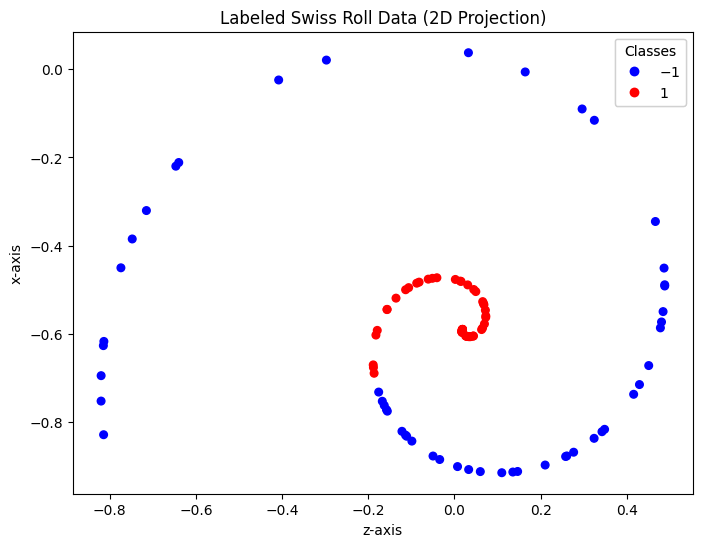

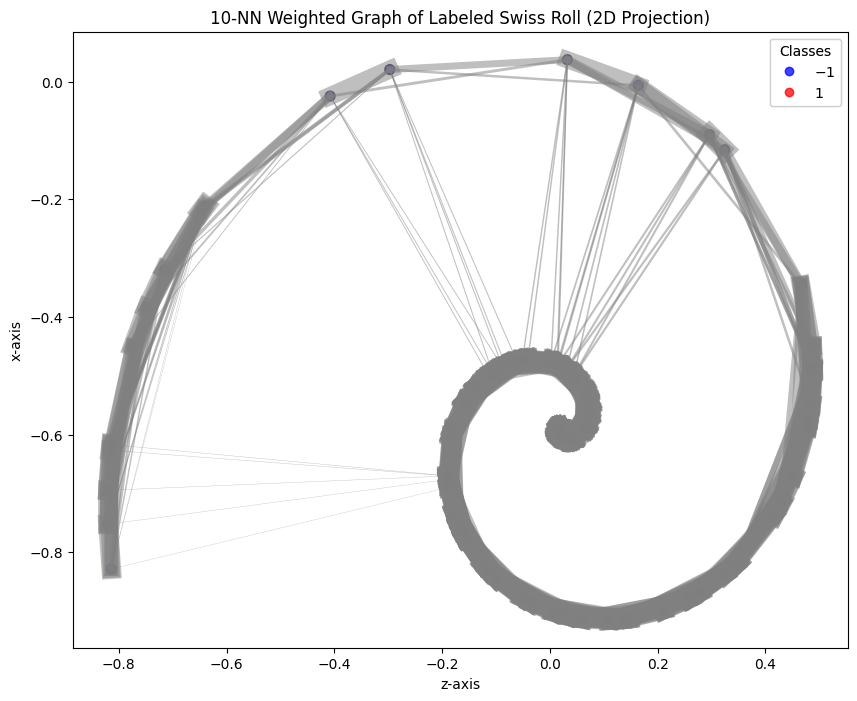

In [14]:
# Cell 3: Generate Swiss Roll Data with Weighted Edges and Enhanced Transformations

import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def generate_weighted_swiss_roll_graph(n_samples=100, scale=10, k=6, seed=5, return_extra=False):
    """
    Generates a transformed Swiss Roll dataset, constructs a weighted adjacency matrix based on inverse distances,
    computes the normalized Laplacian, and optionally plots and returns additional data for visualization.

    Parameters:
        n_samples (int): Number of samples in the Swiss Roll.
        scale (float): Scale parameter for the RBF kernel in adjacency.
        k (int): Number of nearest neighbors for graph construction.
        seed (int): Random seed for reproducibility.
        return_extra (bool): If True, also return t and a_translated and plot the data.
                             Default: False (returns only adj, L_test, target_eigenvals, target_ev).

    Returns:
        If return_extra=False:
            adj (torch.Tensor): Weighted adjacency matrix (shape: [n_samples, n_samples]).
            L_test (torch.Tensor): Normalized Laplacian matrix (shape: [n_samples, n_samples]).
            target_eigenvals (torch.Tensor): Eigenvalues of the Laplacian (shape: [n_samples]).
            target_ev (numpy.ndarray): Eigenvectors of the Laplacian (shape: [n_samples, n_samples]).

        If return_extra=True:
            t (torch.Tensor): Parameter array for the Swiss Roll (shape: [1, n_samples]).
            a_translated (torch.Tensor): The transformed coordinates of the Swiss Roll (shape: [1, n_samples, 2]).
            adj (torch.Tensor)
            L_test (torch.Tensor)
            target_eigenvals (torch.Tensor)
            target_ev (numpy.ndarray)
    """
    # Set seeds for reproducibility
    #torch.manual_seed(seed)
   # np.random.seed(seed)

    # Generate Swiss Roll data
    t, a = gen_random_data(1, n_samples, type='swissroll')  # t: [1, n_samples], a: [1, n_samples, 2]

    # Apply random scaling
    scale_factor = np.random.uniform(0.8, 1.2)  # Scaling between 0.8 and 1.2
    a_scaled = a * scale_factor

    # Apply random rotation
    theta = np.random.uniform(0, 2 * np.pi)  # Rotation angle between 0 and 2π radians
    rotation_matrix = torch.tensor([[np.cos(theta), -np.sin(theta)],
                                    [np.sin(theta),  np.cos(theta)]], dtype=torch.float32)
    a_rotated = torch.matmul(a_scaled, rotation_matrix)  # Shape: [1, n_samples, 2]

    # Apply random translation
    translation_x = np.random.uniform(-1, 1)  # Translation between -1 and 1 units on X-axis
    translation_y = np.random.uniform(-1, 1)  # Translation between -1 and 1 units on Y-axis
    translation = torch.tensor([[[translation_x, translation_y]]], dtype=torch.float32)
    a_translated = a_rotated + translation  # Shape: [1, n_samples, 2]

    # Compute weighted adjacency matrix using inverse RBF distances
    inv_distances = random_data_to_adjacency(a_translated, scale=scale)  # Shape: [1, n_samples, n_samples]

    # Construct k-NN adjacency matrix based on smallest inverse distances
    knn_indices = smallest_k_indices(inv_distances[0, :, :], k)  # Shape: [n_samples, k]
    adj = torch.zeros((n_samples, n_samples), dtype=torch.float32)
    for i in range(knn_indices.shape[0]):
        for j in knn_indices[i, :]:
            if j < n_samples:
                # Use weighted edges
                weight = inv_distances[0, i, j].item()
                adj[i, j] = weight
                adj[j, i] = weight  # Ensure symmetry

    # Compute normalized Laplacian
    degree = torch.sum(adj, dim=1)
    degree[degree == 0] = 1.0  # Avoid division by zero
    D_inv_sqrt = torch.diag(degree.pow(-0.5))
    L_test = torch.eye(adj.size(0)) - D_inv_sqrt @ adj @ D_inv_sqrt

    # Compute eigenvalues and eigenvectors
    target_eigenvals, target_ev_torch = torch.linalg.eigh(L_test)
    target_ev = target_ev_torch.cpu().numpy()  # Convert to NumPy for consistency

    if return_extra:
        # Perform plotting
        data = a_translated[0].cpu().numpy()  # Shape: [n_samples, 2]

        # Assign labels based on the median of t
        labels = np.where(t[0].cpu().numpy() < np.median(t[0].cpu().numpy()), 1, -1)

        # Plot the labeled Swiss Roll data (2D Projection)
        fig, ax = plt.subplots(figsize=(8, 6))
        scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.bwr, s=30)
        ax.set_xlabel('z-axis')
        ax.set_ylabel('x-axis')
        ax.set_title('Labeled Swiss Roll Data (2D Projection)')
        legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend1)
        plt.show()

        # Convert adjacency matrix to NumPy array
        A = adj.numpy()

        # Create NetworkX graph from adjacency matrix
        G = nx.from_numpy_array(A)

        # Plot the weighted k-NN graph
        fig, ax = plt.subplots(figsize=(10, 8))
        # Draw nodes with labels
        scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.bwr, s=50, edgecolor='k', alpha=0.7)

        # Draw edges with linewidth based on weight
        for (i, j) in G.edges():
            weight = A[i, j]
            if weight > 0:
                ax.plot(
                    [data[i, 0], data[j, 0]],
                    [data[i, 1], data[j, 1]],
                    color='gray',
                    linewidth=weight * 15,  # Scale linewidth for better visibility
                    alpha=0.5
                )

        ax.set_xlabel('z-axis')
        ax.set_ylabel('x-axis')
        ax.set_title(f'{k}-NN Weighted Graph of Labeled Swiss Roll (2D Projection)')
        legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend1)
        plt.show()

        return t, a_translated, adj, L_test, target_eigenvals, target_ev
    else:
        return adj, L_test, target_eigenvals, target_ev


# Example usage 
k=10
# Generate one randomly transformed Swiss Roll graph with additional outputs for plotting
t_demo, a_translated_demo, adj_demo, L_test_demo, target_eigenvals_demo, target_ev_demo = generate_weighted_swiss_roll_graph(
    n_samples=100,
    scale=10,
    k=10,
    seed=42,          # Seed for reproducibility; change if randomness is desired
    return_extra=True  # Enable returning additional data for plotting
)

In [15]:
%%capture output
# Cell 4: Training the Transformer with Data Regeneration and Gradient Clipping

# Ensure GPU usage if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Parameters
batch_size = 500
n_samples = 100
k_values = 10
n_layer = 6
n_head = 4
var = 0.1
lr = 0.004
max_iters = 301
stride = 100
clip_r = 1

k_feat = 4

# Compute the maximum number of edges
max_k = max(k_values if isinstance(k_values, (list, tuple)) else [k_values])
max_edges = n_samples * max_k  # Each node connects to k neighbors

n_nodes = n_samples
d = n_samples  # d is used as n_nodes in other parts

model = Transformer_E(n_layer, n_head, n_nodes, d=n_nodes, k=k_feat, var=var).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.99), weight_decay=0.001)

# According to model architecture: Z.shape[2] = d+(n+k) = n+(n+k)=2*n+k_feat
Z = torch.zeros([batch_size, n_nodes, 2*n_nodes + k_feat], device=device)

def generate_batch_swiss_roll_graphs(Z, batch_size, n_samples, k_values, max_edges, noise=0.0, base_seed=0):
    """
    Now we store:
    - Normalized Laplacian in Z[:, :, :n]
    - Adjacency in Z[:, :, n:2n]
    - Eigenvectors in Z[:, :, 2n:]
    """
    if isinstance(k_values, int):
        k_values = [k_values]
    
    for i in range(batch_size):
        # Use the iteration number or base_seed + i as the seed
        seed = base_seed + i  # Ensures different seeds for each graph
        
        adj, L_test, eigenvals, eigenvecs = generate_weighted_swiss_roll_graph(
            n_samples=n_samples,
            scale=10,
            k=k_values[0] if isinstance(k_values, list) else k_values,
            seed=seed,  # Use the seed based on iteration number
            return_extra=False
        )

        # Use the normalized Laplacian directly
        lap = L_test.to(device)  # L_test is the normalized Laplacian
        
        # Select and normalize eigenvectors
        eigenvecs_selected = eigenvecs[:, :k_feat]
        eigenvecs_selected /= (np.linalg.norm(eigenvecs_selected, axis=1, keepdims=True) + 1e-10)
        eigenvecs_selected = torch.from_numpy(eigenvecs_selected).float().to(device)

        # Fill Z
        Z[i, :, :n_nodes] = lap                    # [n, n], normalized Laplacian
        Z[i, :, n_nodes:2*n_nodes] = adj.to(device)   # [n, n]
        Z[i, :, 2*n_nodes:] = eigenvecs_selected      # [n, k_feat]        
        
        
# Initial data generation
generate_batch_swiss_roll_graphs(Z, batch_size, n_samples, k_values, max_edges)

residual_lr = lr
losses = []

# Specify eigenvector indices to compute the loss over
eigen_indices = list(range(0, k_feat))  # eigenvectors 1 to k_feat

for t in range(max_iters):
    optimizer.param_groups[0]['lr'] = residual_lr
    if t % (int(max_iters/7)) == 0 and t > 1:
        residual_lr = residual_lr * 0.5

    if t % stride == 0:
        # e.g. hist_dict[t] = model.allparam.clone().detach().cpu()
        pass

    # Move the data regeneration before loss computation
    if t % 10 == 0 and t > 0:
        generate_batch_swiss_roll_graphs(Z, batch_size, n_samples, k_values, max_edges, base_seed=t*batch_size)
    
    visualize = (t % 10 == 0)
    cur_inds = [0] if t < 1 else [0,1,2,3]
    loss = L_ev_loss(model, Z, inds=cur_inds, k=k_feat, visualize=visualize, t=t)

    # Backprop and step
    loss.backward()
    fraction = clip_and_step(model.allparam, optimizer, clip_r=clip_r)
    norms = model.allparam.grad.norm().item()
    optimizer.zero_grad()

    # Store loss
    losses.append(loss.item())

    # Print progress
    if t % 10 == 0 or t < 5:
        print('iter {} | Loss: {:.3f}, gradnorm: {:.2f}, fraction: {:.4f}'\
              .format(t, loss.item(), norms, fraction))

print("Saving model...")
torch.save(model.state_dict(), "pe_tf.pth")
print("Model saved to pe_tf.pth")

In [17]:
ev_0_loss = L_ev_loss(model, Z[:,:,:], inds=[0],k=4).detach()
ev_1_loss = L_ev_loss(model, Z[:,:,:], inds=[1],k=4).detach()
ev_2_loss = L_ev_loss(model, Z[:,:,:], inds=[2],k=4).detach()
ev_3_loss = L_ev_loss(model, Z[:,:,:], inds=[3],k=4).detach()

print('Losses')
print('ev0: {}'.format(ev_0_loss))
print('ev1: {}'.format(ev_1_loss))
print('ev2: {}'.format(ev_2_loss))
print('ev3: {}'.format(ev_3_loss))

Losses
ev0: 0.05191311985254288
ev1: 0.047016680240631104
ev2: 0.07514101266860962
ev3: 0.05782455578446388


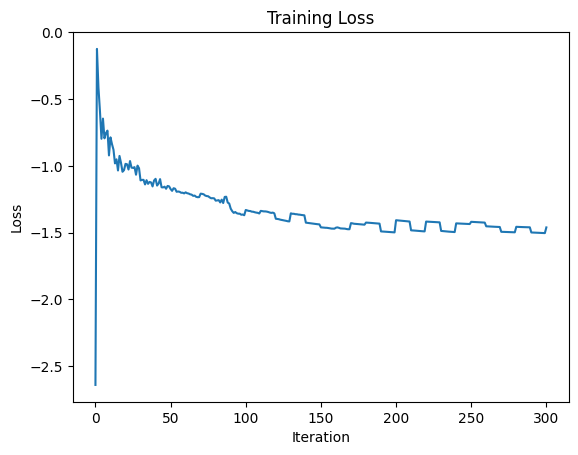

In [18]:
import math

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot([math.log(x) for x in losses])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [19]:
# Cell 5: Run 10 Additional Training Steps Including Test Case and Compute Loss

# NOTE:
#  • Do NOT recreate model or optimizer here. We will reuse the existing `model` 
#    and `optimizer` that were trained/created in Cell 4.
#  • Ensure you have not redefined or reinitialized `losses` in Cell 5.
#    We will append new loss values to the same `losses` list from Cell 4.

# Generate the Test Case with Fixed Seed
seed_for_test = 15
adj_test, L_test, target_eigenvals_test, target_ev_test = generate_weighted_swiss_roll_graph(
    n_samples=n_samples,
    scale=10,
    k=k_values if isinstance(k_values, int) else k_values[0],
    seed=seed_for_test,
    return_extra=False
)

# Convert adjacency to incidence matrix
B_test_cpu, n_edges_test = adjacency_to_incidence(adj_test.cpu(), n_samples, max_edges)
B_test = B_test_cpu.to(device)

# Select and normalize the first k_feat eigenvectors
eigenvecs_selected_test = target_ev_test[:, :k_feat]
eigenvecs_selected_test = eigenvecs_selected_test / (np.linalg.norm(eigenvecs_selected_test, axis=1, keepdims=True) + 1e-10)

# Prepare Z_test as [1, n, 2n + k_feat] = [1, 100, 204]
Z_test = torch.zeros((1, n_samples, 2*n_samples + k_feat), device=device)
Z_test[0, :, :n_samples] = L_test.to(device)              # Normalized Laplacian
Z_test[0, :, n_samples:2*n_samples] = adj_test.to(device) # Adjacency matrix
Z_test[0, :, 2*n_samples:] = torch.from_numpy(eigenvecs_selected_test).float().to(device)  # Eigenvectors

# Evaluate the model on Z_test (Before additional 10 steps)
model.eval()
with torch.no_grad():
    # Compute the loss against the target eigenvectors
    test_loss = L_ev_loss(model, Z_test, inds=list(range(k_feat)), k=k_feat)
    
    # Create all-ones eigenvectors normalized to unit length
    all_ones_vectors = np.ones((n_samples, k_feat))
    all_ones_vectors /= np.linalg.norm(all_ones_vectors, axis=0, keepdims=True)  # Normalize
    
    # Compute the loss against all-ones eigenvectors
    all_ones_torch = torch.tensor(all_ones_vectors, dtype=torch.float32, device=device)
    Z_test_all_ones = Z_test.clone()
    Z_test_all_ones[0, :, 2*n_samples:] = all_ones_torch
    loss_all_ones = L_ev_loss(model, Z_test_all_ones, inds=list(range(k_feat)), k=k_feat)

print("Test Loss on one randomly generated Swiss roll graph pre 10 steps:", test_loss.item())
print("Test Loss with all-ones eigenvectors pre 10 steps:", loss_all_ones.item())

# Initialize the Training Batch and Include Z_test
Z_train = torch.zeros([batch_size, n_nodes, 2*n_nodes + k_feat], device=device)

# Number of times to include Z_test in the batch
num_test_copies = 499  # Adjust as needed to ensure sufficient influence

# Insert multiple copies of Z_test into Z_train
for i in range(num_test_copies):
    Z_train[i] = Z_test

# Fill the rest of Z_train with randomly generated graphs
for i in range(num_test_copies, batch_size):
    # Generate a randomly transformed Swiss roll graph
    adj, L_train, eigenvals_train, eigenvecs_train = generate_weighted_swiss_roll_graph(
        n_samples=n_samples,
        scale=10,
        k=k_values,
        seed=np.random.randint(0, 10000),
        return_extra=False
    )

    # Convert adjacency to incidence matrix
    A_cpu = adj.cpu()
    B, n_edges = adjacency_to_incidence(A_cpu, n_samples, max_edges)
    B = B.to(device)

    # Compute Laplacian = B B^T
    # lap = B @ B.transpose(0,1)  # Shape: [n, n]
    lap = L_train

    # Select and normalize eigenvectors
    eigenvecs_selected = eigenvecs_train[:, :k_feat]
    eigenvecs_selected /= (np.linalg.norm(eigenvecs_selected, axis=1, keepdims=True) + 1e-10)

    # Fill Z_train
    Z_train[i, :, :n_nodes]             = lap                       # [n, n]
    Z_train[i, :, n_nodes:2*n_nodes]    = adj.to(device)            # [n, n]
    Z_train[i, :, 2*n_nodes:]          = torch.from_numpy(eigenvecs_selected).float().to(device)  # [n, k_feat]

# Replace Z with Z_train for these 10 additional steps
Z = Z_train

# Run 10 Additional Training Iterations
residual_lr = optimizer.param_groups[0]['lr']  # keep the current LR from Cell 4
print("\n--- Starting 10 more training iterations ---\n")
for t_test in range(10):
    model.train()
    
    # Set learning rate
    optimizer.param_groups[0]['lr'] = residual_lr

    # Compute loss over specified eigenvectors
    cur_inds = list(range(k_feat))  # typically [0,1,2,3]
    loss = L_ev_loss(model, Z, inds=cur_inds, k=k_feat)

    # Backpropagation and optimization step
    loss.backward()
    fraction = clip_and_step(model.allparam, optimizer, clip_r=clip_r)
    norms = model.allparam.grad.norm().item()
    optimizer.zero_grad()

    # Append new loss to the existing 'losses' from Cell 4
    losses.append(loss.item())

    print(f"Additional training iter {t_test+1} | Loss: {loss.item():.4f}, Grad Norm: {norms:.2f}, Fraction: {fraction:.4f}")

# Compute Loss Metrics on the Same Test Case After the Additional 10 Steps
model.eval()
with torch.no_grad():
    # Compute the loss on Z_test
    test_loss_after_training = L_ev_loss(model, Z_test, inds=list(range(k_feat)), k=k_feat)

    # Compute L2 norm of target eigenvectors
    target_eigenvector_norms = np.linalg.norm(eigenvecs_selected_test, axis=0)
    
    # Compute the loss with all-ones vectors
    all_ones_vectors = np.ones((n_samples, k_feat))
    all_ones_vectors /= np.linalg.norm(all_ones_vectors, axis=0, keepdims=True) + 1e-10
    all_ones_torch = torch.tensor(all_ones_vectors, dtype=torch.float32, device=device)
    
    Z_test_all_ones = Z_test.clone()
    Z_test_all_ones[0, :, 2*n_samples:] = all_ones_torch
    
    loss_all_ones_after_training = L_ev_loss(model, Z_test_all_ones, inds=list(range(k_feat)), k=k_feat)

print("\nAfter 10 Additional Training Iterations:")
print(f"Test Loss on the test graph: {test_loss_after_training.item():.4f}")
print(f"Loss when compared to all-ones eigenvectors: {loss_all_ones_after_training.item():.4f}")

print("\nL2 Norms of Target Eigenvectors (per eigenvector):", target_eigenvector_norms)

# The global 'losses' list now includes both:
#   - The original training losses (from Cell 4's 3001 steps), and
#   - The 10 new losses from this cell.
print(f"\nLength of the combined 'losses' list: {len(losses)}")


Test Loss on one randomly generated Swiss roll graph pre 10 steps: 0.14845439791679382
Test Loss with all-ones eigenvectors pre 10 steps: 6.775558948516846

--- Starting 10 more training iterations ---

Additional training iter 1 | Loss: 0.1485, Grad Norm: 0.96, Fraction: 1.0000
Additional training iter 2 | Loss: 0.1485, Grad Norm: 1.00, Fraction: 0.5228
Additional training iter 3 | Loss: 0.1485, Grad Norm: 1.00, Fraction: 0.5111
Additional training iter 4 | Loss: 0.1485, Grad Norm: 1.00, Fraction: 0.5111
Additional training iter 5 | Loss: 0.1485, Grad Norm: 1.00, Fraction: 0.5111
Additional training iter 6 | Loss: 0.1485, Grad Norm: 1.00, Fraction: 0.5111
Additional training iter 7 | Loss: 0.1485, Grad Norm: 1.00, Fraction: 0.5111
Additional training iter 8 | Loss: 0.1485, Grad Norm: 1.00, Fraction: 0.5111
Additional training iter 9 | Loss: 0.1485, Grad Norm: 1.00, Fraction: 0.5111
Additional training iter 10 | Loss: 0.1485, Grad Norm: 1.00, Fraction: 0.5111

After 10 Additional Train

In [20]:
import torch.nn.functional as F

# Training: Given n labeled samples, select m samples to be "unlabeled" queries.
# Then the contextual dataset is (n-m) labeled contextual examples and m "unlabeled" queries.
# During training, the loss is computed on the m "unlabeled" queries. During evaluation, we use all labeled samples and predict the unlabeled ones.
class InContextClassifier(nn.Module):
    def __init__(self, n_layers=2, n_categories=2, kernel='linear', pe_dim=4):
        super().__init__()
        # Basic settings
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.n_layers = n_layers
        self.pe_dim = pe_dim
        self.n_categories = n_categories
        self.n_outputs = 5
        self.kernel = kernel
        
        # Initialize transformation matrices
        self.W_Q = torch.zeros((pe_dim + 2*self.n_outputs, pe_dim + 2*self.n_outputs)).to(self.device)
        self.W_K = torch.zeros((pe_dim + 2*self.n_outputs, pe_dim + 2*self.n_outputs)).to(self.device)
        self.W_V = torch.zeros((pe_dim + 2*self.n_outputs, pe_dim + 2*self.n_outputs)).to(self.device)

        # Identity matrices for feature transformations
        self.W_Q[:pe_dim, :pe_dim] = torch.eye(pe_dim).to(self.device)
        self.W_K[:pe_dim, :pe_dim] = torch.eye(pe_dim).to(self.device)
        
        # Scale value transformations
        n_samples = 100  # Match with pipeline
        self.W_V[pe_dim:pe_dim+self.n_outputs, pe_dim:pe_dim+self.n_outputs] = torch.eye(self.n_outputs).to(self.device)
        
        # Initialize learnable parameters
        self.M = nn.Parameter(torch.randn(self.n_outputs, self.n_outputs).to(self.device) * 0.1)
        self.alpha = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.gamma = nn.Parameter(torch.tensor(1e-1).to(self.device))
        self.kernel_param = nn.Parameter(torch.ones(1), requires_grad=True)
        
        # Initialize initial embedding matrix
        self.embedding_matrix = nn.Parameter(torch.randn(self.n_outputs, n_categories).to(self.device))
        
    def _encode_labels(self, labels):
        """Encode labels into one-hot vectors"""
        encoded = F.one_hot(labels, num_classes=self.n_categories).to(self.device)
        # encoded = encoded[:, :, :-1]  # Remove last category
        return encoded

    def get_attention_scores(self, Q, K):
        """Compute attention scores based on kernel type"""
        if self.kernel == 'linear':
            return self.kernel_param * torch.einsum('bdi,bdj->bij', Q, K)
        elif self.kernel == 'exp':
            scores = torch.einsum('bdi,bdj->bij', Q, K)
            return torch.exp(scores / self.kernel_param)
        elif self.kernel == 'rbf':
            diff = Q.unsqueeze(-1) - K.unsqueeze(-2)
            sqdist = torch.sum(diff ** 2, dim=1)
            return torch.exp(-sqdist / (2 * self.kernel_param ** 2))
        elif self.kernel == 'softmax':
            scores = torch.einsum('bdi,bdj->bij', Q, K) / math.sqrt(Q.size(1))
            return F.softmax(scores, dim=-1)
        else:
            raise ValueError(f"Unknown kernel type: {self.kernel}")

    def attention_layer(self, query_encoded, context_encoded, P):
        """GDPP attention mechanism"""
        n_context = context_encoded.shape[-2]
        
        Q = torch.matmul(self.W_Q, query_encoded)
        K = torch.matmul(self.W_K, context_encoded)
        
        attention_weights = self.get_attention_scores(Q, K)
        V = torch.matmul(self.alpha * self.W_V, context_encoded)
        
        attention_weights = attention_weights.unsqueeze(2)
        context = V.unsqueeze(1) * attention_weights
        if kernel != 'softmax':
            context = context * 1 / n_context
        context = torch.sum(context, dim=-1)
        
        context = context.permute(0, 2, 1)
        return torch.matmul(P, context)

    def _prepare_inputs(self, pe_features, labels=None):
        """Prepare inputs for GDPP attention"""
        batch_size = pe_features.shape[0]
        n_samples = pe_features.shape[1]
        if labels is None:
            one_hot_yi = torch.zeros(batch_size, n_samples, self.n_categories).to(device)
            centered_yi = one_hot_yi - (1 / self.n_categories)
        else:
            encoded = self._encode_labels(labels)
            centered_yi = encoded - 1 / self.n_categories
        import pdb

        encoded_vectors = torch.cat([
            pe_features,
            torch.matmul(self.embedding_matrix, centered_yi.transpose(1, 2)).transpose(1, 2),
            torch.zeros(batch_size, n_samples, self.n_outputs).to(self.device)
        ], dim=2)
        
        return encoded_vectors

    def forward(self, pe_features, labels=None, context_indices=None, query_indices=None):
        """Forward pass implementing GDPP logic while maintaining Aaron's interface"""
        if labels is None or context_indices is None:
            return torch.ones(len(pe_features), self.n_outputs).to(self.device) / self.n_categories

        batch_size = pe_features.shape[0]
        n_samples = pe_features.shape[1]
        
        # Initialize projection matrix P
        P = torch.zeros((self.pe_dim + 2*self.n_outputs, self.pe_dim + 2*self.n_outputs)).to(self.device)
        P[self.pe_dim:self.pe_dim+self.n_outputs, self.pe_dim:self.pe_dim+self.n_outputs] = -self.M
        P[self.pe_dim + self.n_outputs:, self.pe_dim:self.pe_dim + self.n_outputs] = torch.eye(self.n_outputs).to(self.device)
        
        # Prepare context and query data
        context_pe = pe_features[torch.arange(batch_size).unsqueeze(-1), context_indices]
        context_labels = labels.gather(-1, context_indices)
        query_pe = pe_features[torch.arange(batch_size).unsqueeze(-1), query_indices]
        import pdb
        # Prepare inputs
        context_z = self._prepare_inputs(context_pe, context_labels)
        query_z = self._prepare_inputs(query_pe)
        
        # Concatenate for full processing
        full_z = torch.cat([context_z, query_z], dim=1).transpose(1, 2)
        context_z = context_z.transpose(1, 2)
        
        # Initialize predictions
        current_h = torch.ones([batch_size, n_samples, self.n_outputs]).to(self.device) / self.n_categories
        
        # Apply multiple layers of attention
        for _ in range(self.n_layers):
            attention_output = self.attention_layer(full_z, context_z, P)
            full_z = attention_output + full_z
            context_z = context_z + attention_output[:, :, :context_z.size(2)]
            
        # Extract final predictions
        predictions = full_z[:, -self.n_outputs:, :]
        # predictions = predictions.transpose(1, 2)
        # import pdb
        # pdb.set_trace()
        # Add the last category probability
        # predictions = torch.cat([predictions, 1 - predictions.sum(dim=-1, keepdim=True)], dim=-1)
        
        return predictions

    def train_step(self, pe_features, labels, labeled_indices, context_indices, query_indices):
        """Training step maintaining Aaron's interface"""
        pe_features = pe_features.to(self.device)
        labels = labels.to(self.device).long()
        
        batch_size, n_samples, _ = pe_features.shape
        n_labeled = labeled_indices.shape[-1]
        context_size = context_indices.shape[-1]
        query_size = n_samples - context_size
        
        labeled_indices = labeled_indices.to(self.device)
        context_indices = context_indices.to(self.device)
        query_indices = query_indices.to(self.device)
        
        labeled_pe_features = pe_features[torch.arange(batch_size).unsqueeze(-1), labeled_indices]
        
        # Get predictions
        out = self.forward(labeled_pe_features, labels, context_indices, query_indices)
        
        softmax_input = torch.matmul(self.embedding_matrix.T, out)
        softmax_input = softmax_input.squeeze(-1)
        predicted_y_probabilities = torch.softmax(softmax_input, dim=1)
        predicted_category = torch.argmax(predicted_y_probabilities, dim=1)
        predicted_logits = predicted_y_probabilities.squeeze(-1).float()
        criterion = nn.CrossEntropyLoss()
        out = predicted_logits
        
        # Split predictions for context and query
        context_pred = out[:, :,:context_size]
        query_pred = out[:, :, context_size:]
        
        # Get corresponding labels
        context_labels = labels.gather(-1, context_indices)
        query_labels = labels.gather(-1, query_indices)
        
        # Compute losses
        criterion = nn.CrossEntropyLoss()
        
        # Reshape logits for CrossEntropyLoss
        context_pred = context_pred.permute(0, 2, 1)  # [batch_size, context_size, n_categories]
        query_pred = query_pred.permute(0, 2, 1)      # [batch_size, query_size, n_categories]
        
        # Flatten batch and samples dimensions
        context_pred = context_pred.reshape(-1, self.n_categories)  # [batch_size*context_size, n_categories]
        query_pred = query_pred.reshape(-1, self.n_categories)      # [batch_size*query_size, n_categories]
        context_labels = context_labels.reshape(-1)                      # [batch_size*context_size]
        query_labels = query_labels.reshape(-1)                         # [batch_size*query_size]
        
        # Compute losses
        context_loss = criterion(context_pred, context_labels)
        query_loss = criterion(query_pred, query_labels)

        # # Compute losses
        # context_prob = context_pred.gather(-1, context_labels.unsqueeze(-1)).squeeze(-1)
        # # context_loss = F.mse_loss(context_prob, torch.ones_like(context_prob))
        # context_loss = criterion(predicted_logits, context_labels)
        # query_prob = query_pred.gather(-1, query_labels.unsqueeze(-1)).squeeze(-1)
        # # query_loss = F.mse_loss(query_prob, torch.ones_like(query_prob))
        # context_loss = criterion(query_prob, query_labels)
        # # Combine losses
        total_loss = context_size / n_labeled * context_loss + query_size / n_labeled * query_loss
        # import pdb
        # pdb.set_trace()
        # # Compute accuracy
        # Compute accuracy on query predictions
        pred_categories = query_pred.argmax(dim=-1)  # [batch_size*query_size]
        query_accuracy = (pred_categories == query_labels).float().mean()
        
        # Reshape predicted categories back to original shape
        query_pred_labels = pred_categories.reshape(batch_size, query_size)
        # query_pred_labels = query_pred.argmax(dim=-1)
        # query_accuracy = (query_pred_labels == query_labels).float().mean()
        
        return total_loss, context_loss, query_loss, query_accuracy, query_pred_labels
    
# Train the ICL Transformer with Embeddings from a PE Transformer with Fixed Weights.

# Ensure GPU usage if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

def generate_in_context_swiss_roll_graphs(Z, batch_size, n_samples, k_values, max_edges, noise=0.0, base_seed=0, k_feat=4, label_percent=100, context_size=0, model=None, use_exact_ev=False):
    """
    Now we store:
    - Normalized Laplacian in Z[:, :, :n]
    - Adjacency in Z[:, :, n:2n]
    - Eigenvectors in Z[:, :, 2n:]
    """
    assert label_percent > 0 and label_percent <= 100
    n_labeled = int(n_samples * label_percent / 100)
    
    assert context_size < n_labeled
    
    if isinstance(k_values, int):
        k_values = [k_values]

    if use_exact_ev:
        embedding = torch.zeros([batch_size, n_samples, k_feat], device=device)
    
    for i in range(batch_size):
        # Use the iteration number or base_seed + i as the seed
        seed = base_seed + i  # Ensures different seeds for each graph
        
        adj, L_test, eigenvals, eigenvecs = generate_weighted_swiss_roll_graph(
            n_samples=n_samples,
            scale=10,
            k=k_values[0] if isinstance(k_values, list) else k_values,
            seed=seed,  # Use the seed based on iteration number
            return_extra=False
        )

        # Use the normalized Laplacian directly
        lap = L_test.to(device)  # L_test is the normalized Laplacian
        
        # Select and normalize eigenvectors
        eigenvecs_selected = eigenvecs[:, :k_feat]
        eigenvecs_selected /= (np.linalg.norm(eigenvecs_selected, axis=1, keepdims=True) + 1e-10)
        eigenvecs_selected = torch.from_numpy(eigenvecs_selected).float().to(device)

        # Fill Z
        Z[i, :, :n_nodes] = lap                    # [n, n], normalized Laplacian
        Z[i, :, n_nodes:2*n_nodes] = adj.to(device)   # [n, n]
        Z[i, :, 2*n_nodes:] = eigenvecs_selected      # [n, k_feat]        

        if use_exact_ev:
            actual_embedding = eigenvecs[:, :k_feat]  # [n_samples, k_feat]
            embedding[i, :, :] = torch.from_numpy(actual_embedding / (np.linalg.norm(actual_embedding, axis=1, keepdims=True) + 1e-10)).float().to(device)
            
    if not use_exact_ev:
        # Make predictions with PE transformer
        model.eval()
        with torch.no_grad():
            output = model(Z)  # Shape: [batch_size, n_samples, n + (n+k)]
            # Extract predicted eigenvectors
            predicted_ev = output[:, :, -k_feat:].cpu().numpy()  # [batch_size, n_samples, k_feat]
        
        # Predicted embedding
        embedding = predicted_ev / (np.linalg.norm(predicted_ev, axis=1, keepdims=True) + 1e-10)
        embedding = torch.from_numpy(embedding).float().to(device)

    # Assign labels based on t for visualization
    # We have 't' from Cell 6 or we can re-generate t using the same seed and n_samples
    t, data = gen_random_data(batch_size, n_samples, type='swissroll')
    data = data.to(device)
    labels = torch.from_numpy(np.where(t.cpu().numpy() < np.median(t.cpu().numpy()), 1, 0)).to(device)
    
    # Get labeled indices
    labeled_indices = torch.stack([torch.randperm(n_samples)[:n_labeled] for _ in range(batch_size)]).to(device)
    labeled_data = labels.gather(-1, labeled_indices)
    
    # Get context indices
    context_indices = torch.stack([torch.randperm(n_labeled)[:context_size] for _ in range(batch_size)]).to(device)
    
    all_indices = torch.arange(n_labeled).expand(batch_size, n_labeled).to(device)  # Shape [B, n_labeled]

    # Create a mask for indices present in the input tensor
    mask = torch.zeros(batch_size, n_labeled, dtype=torch.bool).to(device)
    mask.scatter_(1, context_indices, True)
            
    # Invert the mask to get query indices
    query_indices = all_indices[~mask].view(batch_size, n_labeled - context_size).to(device)  # Shape [B, n_labeled - context_size]
    
    return embedding, labeled_data, labeled_indices, context_indices, query_indices

def train_icl_fixed_pe(batch_size=500, n_samples=100, k_values=10, n_layer=2, lr=0.004, max_iters=301, k_feat=4, label_percent=100, context_size=99, 
                       kernel='linear', use_exact_ev=False, pe_model=None, save_path=None):
    """
        Trains ICL Transformer using predicted embeddings from PE Transformer with fixed weights.
    """
    query_size = n_samples - context_size
    pe_dim = k_feat
    
    # Compute the maximum number of edges
    max_k = max(k_values if isinstance(k_values, (list, tuple)) else [k_values])
    max_edges = n_samples * max_k  # Each node connects to k neighbors
    
    n_nodes = n_samples
    d = n_samples

    # Initialize model
    icl_model = InContextClassifier(n_layers=n_layer, n_categories=2, kernel=kernel, pe_dim=pe_dim).to(device)
    
    # # Define optimizer
    icl_optimizer = torch.optim.AdamW([{'params': [icl_model.alpha, icl_model.kernel_param]}], lr=lr, betas=(0.9, 0.99), weight_decay=0.001)

    # Define optimizer
    # icl_optimizer = torch.optim.AdamW([{'params': icl_model.parameters()}], lr=lr, betas=(0.9, 0.99), weight_decay=0.001)

    # According to model architecture: Z.shape[2] = d+(n+k) = n+(n+k)=2*n+k_feat
    Z = torch.zeros([batch_size, n_nodes, 2*n_nodes + k_feat], device=device)
    
    # Initial data generation
    predicted_embedding, labels, labeled_indices, context_indices, query_indices = generate_in_context_swiss_roll_graphs(Z, batch_size, n_samples, k_values, max_edges, 
                                                                        k_feat=k_feat, label_percent=label_percent, context_size=context_size, 
                                                                                                        model=pe_model, use_exact_ev=use_exact_ev)
    
    residual_lr = lr
    icl_losses = []
    icl_acc = []
    
    # Specify eigenvector indices to compute the loss over
    eigen_indices = list(range(0, k_feat))  # eigenvectors 1 to k_feat
    
    for t in range(max_iters):
        icl_optimizer.param_groups[0]['lr'] = residual_lr
        if t % (int(max_iters/7)) == 0 and t > 1:
            residual_lr = residual_lr * 0.5
    
        # Move the data regeneration before loss computation
        if t % 10 == 0 and t > 0:
            predicted_embedding, labels, labeled_indices, context_indices, query_indices = generate_in_context_swiss_roll_graphs(Z, batch_size, n_samples, k_values, max_edges, base_seed=t*batch_size, 
                                                                                k_feat=k_feat, label_percent=label_percent, context_size=context_size, 
                                                                                                                model=pe_model, use_exact_ev=use_exact_ev)
        
        total_loss, contextual_loss, query_loss, query_accuracy, query_pred_labels = icl_model.train_step(predicted_embedding, labels, labeled_indices, context_indices, query_indices)
        
        # Backprop and step
        icl_optimizer.zero_grad()
        query_loss.backward()
        # fraction = clip_and_step(model.allparam, optimizer, clip_r=clip_r)
        # norms = model.allparam.grad.norm().item()
        icl_optimizer.step()
    
        # Store loss
        icl_losses.append(query_loss.item())
        icl_acc.append(query_accuracy.item())
    
        # Print progress
        if t % 10 == 0 or t < 5:
            print('iter {} | Loss: {:.3f} | Accuracy: {:.3f}'.format(t, query_loss.item(), query_accuracy.item()))
    
    if save_path is not None:
        print("Saving model...")
        torch.save(icl_model.state_dict(), save_path)
        print("Model saved to ", save_path)

    return icl_model, icl_losses, icl_acc


In [ ]:
# Load PE Transformer Weights from Saved Model.

# Ensure GPU usage if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Parameters
batch_size = 500
n_samples = 100
k_values = 10
n_layer = 6
n_head = 4
var = 0.1
lr = 0.004
max_iters = 301
stride = 100
clip_r = 1

k_feat = 4

# Compute the maximum number of edges
max_k = max(k_values if isinstance(k_values, (list, tuple)) else [k_values])
max_edges = n_samples * max_k  # Each node connects to k neighbors

n_nodes = n_samples
d = n_samples  # d is used as n_nodes in other parts

pe_model = Transformer_E(n_layer, n_head, n_nodes, d=n_nodes, k=k_feat, var=var).to(device)
pe_model.load_state_dict(torch.load("models/pe_tf.pth", weights_only=True, map_location=device))

In [22]:
# Train ICL transformer using Actual EVs
icl_model_exact, icl_losses_exact, icl_acc_exact = train_icl_fixed_pe(batch_size=500, 
                                                                      n_samples=100,
                                                                      k_values=10, 
                                                                      n_layer=2, 
                                                                      lr = 0.004, 
                                                                      max_iters=101, 
                                                                      k_feat=4, 
                                                                      context_size=99, 
                                                                      kernel='linear', 
                                                                      use_exact_ev=True, 
                                                                      pe_model=None, 
                                                                      save_path='icl_tf_linear_exact_pe_c_99.pth')

iter 0 | Loss: 0.403 | Accuracy: 0.962
iter 1 | Loss: 0.402 | Accuracy: 0.962
iter 2 | Loss: 0.402 | Accuracy: 0.962
iter 3 | Loss: 0.401 | Accuracy: 0.962
iter 4 | Loss: 0.400 | Accuracy: 0.962
iter 10 | Loss: 0.385 | Accuracy: 0.970
iter 20 | Loss: 0.384 | Accuracy: 0.970
iter 30 | Loss: 0.377 | Accuracy: 0.960
iter 40 | Loss: 0.376 | Accuracy: 0.964
iter 50 | Loss: 0.386 | Accuracy: 0.946
iter 60 | Loss: 0.378 | Accuracy: 0.954
iter 70 | Loss: 0.371 | Accuracy: 0.962
iter 80 | Loss: 0.366 | Accuracy: 0.964
iter 90 | Loss: 0.362 | Accuracy: 0.970
iter 100 | Loss: 0.372 | Accuracy: 0.956
Saving model...
Model saved to  icl_tf_linear_exact_pe_c_99.pth


In [23]:
# Train ICL Transformer with Predicted EVs from PE Transformer

icl_model_pe, icl_losses_pe, icl_acc_pe = train_icl_fixed_pe(batch_size=500, 
                                                             n_samples=100, 
                                                             k_values=10, 
                                                             n_layer=2, 
                                                             lr = 0.004, 
                                                             max_iters=101, 
                                                             k_feat=4, 
                                                             context_size=99, 
                                                             kernel='linear', 
                                                             use_exact_ev=False, 
                                                             pe_model=pe_model, 
                                                             save_path='icl_tf_linear_pred_pe_c_99.pth')

iter 0 | Loss: 0.668 | Accuracy: 0.942
iter 1 | Loss: 0.668 | Accuracy: 0.942
iter 2 | Loss: 0.667 | Accuracy: 0.942
iter 3 | Loss: 0.667 | Accuracy: 0.942
iter 4 | Loss: 0.667 | Accuracy: 0.942
iter 10 | Loss: 0.666 | Accuracy: 0.972
iter 20 | Loss: 0.663 | Accuracy: 0.970
iter 30 | Loss: 0.663 | Accuracy: 0.944
iter 40 | Loss: 0.660 | Accuracy: 0.956
iter 50 | Loss: 0.656 | Accuracy: 0.960
iter 60 | Loss: 0.655 | Accuracy: 0.950
iter 70 | Loss: 0.651 | Accuracy: 0.964
iter 80 | Loss: 0.650 | Accuracy: 0.958
iter 90 | Loss: 0.647 | Accuracy: 0.960
iter 100 | Loss: 0.642 | Accuracy: 0.958
Saving model...
Model saved to  icl_tf_linear_pred_pe_c_99.pth


In [24]:
# Cell 8: Code for End-to-End PE + ICL Transformer.

class JointPEICLTransformer(nn.Module):
    def __init__(self, n_layer_pe, n_head_pe, n, d, k, var, n_layer_icl=2, n_categories=2, kernel='linear', pe_dim=4, pe_weight=1.0, icl_weight=1.0, pe_pretrained=None, icl_pretrained=None):
        super().__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.n_layer_pe = n_layer_pe
        self.n_head_pe = n_head_pe
        self.n = n
        self.d = d
        self.k = k
        self.var = var
        self.n_layer_icl = n_layer_icl
        self.n_categories = n_categories
        self.kernel = kernel
        self.pe_dim = 4
        self.pe_weight = 1.0
        self.icl_weight = 1.0

        self.pe_tf = Transformer_E(n_layer_pe, n_head_pe, n, d, k, var).to(self.device)
        self.icl_tf = InContextClassifier(n_layers=n_layer_icl, n_categories=n_categories, kernel=kernel, pe_dim=pe_dim).to(self.device)
        
        if pe_pretrained is not None:
            self.pe_tf.load_state_dict(torch.load(pe_pretrained, weights_only=True, map_location=device))
            
        if icl_pretrained is not None:
            self.icl_tf.load_state_dict(torch.load(icl_pretrained, weights_only=True, map_location=device))

    def train_step(self, Z, labels=None, labeled_indices=None, context_indices=None, query_indices=None):
        # Get predicted embeddings from PE transformer
        output = self.pe_tf(Z)
        predicted_ev = output[:, :, -self.pe_dim:]  # [batch_size, n_samples, pe_dim]
        
        # Predicted embedding
        predicted_ev = predicted_ev / (torch.linalg.norm(predicted_ev, dim=1, keepdims=True) + 1e-10)
        pe_features = predicted_ev.to(self.device)

        # Get predictions from ICL transformer
        icl_total_loss, icl_context_loss, icl_query_loss, icl_query_accuracy, icl_query_pred_labels = self.icl_tf.train_step(pe_features,
                                                                                                                             labels=labels,
                                                                                                                             labeled_indices=labeled_indices,
                                                                                                                             context_indices=context_indices,
                                                                                                                             query_indices=query_indices)

        cur_inds = range(self.pe_dim)
        pe_loss = self._pe_loss(Z, output, inds=cur_inds, k=self.pe_dim)

        total_loss = self.pe_weight * pe_loss + self.icl_weight * icl_query_loss

        return total_loss, pe_loss, icl_query_loss, icl_query_accuracy, icl_query_pred_labels

    def _pe_loss(self, Z, output, inds=None, k=-1):
        n = Z.shape[1]
        d = Z.shape[2] - n - n
        assert inds is not None
    
        # Get Laplacian and compute eigendecomposition
        lap = Z[:, :, :n]
        eigenvals, target = torch.linalg.eigh(lap)
        target = target.real

        predicted_ev = output[:, :, -k:]
        if inds is not None:
            predicted_ev = predicted_ev[:, :, inds]
            target = target[:, :, inds]
    
        # Normalize
        predicted_ev = predicted_ev / predicted_ev.norm(p=2, dim=1)[:, None, :]
        target = target / target.norm(p=2, dim=1)[:, None, :]
    
        # Compute loss
        loss_pos = ((predicted_ev - target).norm(p=2, dim=[1]) ** 2)
        loss_neg = ((-predicted_ev - target).norm(p=2, dim=[1]) ** 2)
        loss = torch.minimum(loss_pos, loss_neg).sum(dim=1).mean()
        
        return loss

# Train End-to-End Transformer.

# Ensure GPU usage if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

def generate_end_to_end_swiss_roll_graphs(Z, batch_size, n_samples, k_values, max_edges, noise=0.0, base_seed=0, k_feat=4, label_percent=100, context_size=0):
    """
    Now we store:
    - Normalized Laplacian in Z[:, :, :n]
    - Adjacency in Z[:, :, n:2n]
    - Eigenvectors in Z[:, :, 2n:]
    """
    assert label_percent > 0 and label_percent <= 100
    n_labeled = int(n_samples * label_percent / 100)
    
    assert context_size < n_labeled
    
    if isinstance(k_values, int):
        k_values = [k_values]
    
    for i in range(batch_size):
        # Use the iteration number or base_seed + i as the seed
        seed = base_seed + i  # Ensures different seeds for each graph
        
        adj, L_test, eigenvals, eigenvecs = generate_weighted_swiss_roll_graph(
            n_samples=n_samples,
            scale=10,
            k=k_values[0] if isinstance(k_values, list) else k_values,
            seed=seed,  # Use the seed based on iteration number
            return_extra=False
        )

        # Use the normalized Laplacian directly
        lap = L_test.to(device)  # L_test is the normalized Laplacian
        
        # Select and normalize eigenvectors
        eigenvecs_selected = eigenvecs[:, :k_feat]
        eigenvecs_selected /= (np.linalg.norm(eigenvecs_selected, axis=1, keepdims=True) + 1e-10)
        eigenvecs_selected = torch.from_numpy(eigenvecs_selected).float().to(device)

        # Fill Z
        Z[i, :, :n_nodes] = lap                    # [n, n], normalized Laplacian
        Z[i, :, n_nodes:2*n_nodes] = adj.to(device)   # [n, n]
        Z[i, :, 2*n_nodes:] = eigenvecs_selected      # [n, k_feat]        

    # Assign labels based on t for visualization
    # We have 't' from Cell 6 or we can re-generate t using the same seed and n_samples
    t, data = gen_random_data(batch_size, n_samples, type='swissroll')
    data = data.to(device)
    labels = torch.from_numpy(np.where(t.cpu().numpy() < np.median(t.cpu().numpy()), 1, 0)).to(device)

    # Get labeled indices
    labeled_indices = torch.stack([torch.randperm(n_samples)[:n_labeled] for _ in range(batch_size)]).to(device)
    labeled_data = labels.gather(-1, labeled_indices)
    
    # Get context indices
    context_indices = torch.stack([torch.randperm(n_labeled)[:context_size] for _ in range(batch_size)]).to(device)
    
    all_indices = torch.arange(n_labeled).expand(batch_size, n_labeled).to(device)  # Shape [B, n_labeled]

    # Create a mask for indices present in the input tensor
    mask = torch.zeros(batch_size, n_labeled, dtype=torch.bool).to(device)
    mask.scatter_(1, context_indices, True)
            
    # Invert the mask to get query indices
    query_indices = all_indices[~mask].view(batch_size, n_labeled - context_size).to(device)  # Shape [B, n_labeled - context_size]

    return Z, labeled_data, labeled_indices, context_indices, query_indices

def train_end_to_end_pe_icl(n_layer_pe, n_head_pe, n, d, k, var, batch_size=500, n_samples=100, k_values=10, n_layer_icl=2, lr=0.004, max_iters=301, k_feat=4, label_percent=100,
                            context_size=99, 
                       kernel='linear', pe_weight=1.0, icl_weight=1.0, pe_pretrained=None, icl_pretrained=None, save_path=None):
    """ 
        Trains end-to-end PE and ICL Transformer.
    """
    query_size = n_samples - context_size
    pe_dim = k_feat
    
    # Compute the maximum number of edges
    max_k = max(k_values if isinstance(k_values, (list, tuple)) else [k_values])
    max_edges = n_samples * max_k  # Each node connects to k neighbors
    
    n_nodes = n_samples
    d = n_samples

    # Initialize model
    joint_model = JointPEICLTransformer(n_layer_pe, 
                                        n_head_pe, 
                                        n, 
                                        d, 
                                        k, 
                                        var, 
                                        n_layer_icl=n_layer_icl, 
                                        n_categories=2, 
                                        kernel=kernel, 
                                        pe_dim=pe_dim,
                                        pe_weight=pe_weight, 
                                        icl_weight=icl_weight, 
                                        pe_pretrained=pe_pretrained, 
                                        icl_pretrained=icl_pretrained).to(device)
    
    # Define optimizer
    optimizer = torch.optim.AdamW(joint_model.parameters(), lr=lr, betas=(0.9, 0.99), weight_decay=0.001)

    # According to model architecture: Z.shape[2] = d+(n+k) = n+(n+k)=2*n+k_feat
    Z = torch.zeros([batch_size, n_nodes, 2*n_nodes + k_feat], device=device)
    
    # Initial data generation
    Z, labels, labeled_indices, context_indices, query_indices = generate_end_to_end_swiss_roll_graphs(Z, batch_size, n_samples, k_values, max_edges, 
                                                                        k_feat=k_feat, label_percent=label_percent, context_size=context_size)
    
    residual_lr = lr
    losses = []
    pe_losses = []
    icl_query_losses = []
    acc = []
    
    # Specify eigenvector indices to compute the loss over
    eigen_indices = list(range(0, k_feat))  # eigenvectors 1 to k_feat
    
    for t in range(max_iters):
        optimizer.param_groups[0]['lr'] = residual_lr
        if t % (int(max_iters/7)) == 0 and t > 1:
            residual_lr = residual_lr * 0.5
    
        # Move the data regeneration before loss computation
        if t % 10 == 0 and t > 0:
            Z, labels, labeled_indices, context_indices, query_indices = generate_end_to_end_swiss_roll_graphs(Z, batch_size, n_samples, k_values, max_edges, base_seed=t*batch_size, 
                                                                                k_feat=k_feat, label_percent=label_percent, context_size=context_size)
        
        total_loss, pe_loss, icl_query_loss, icl_query_accuracy, icl_query_pred_labels = joint_model.train_step(Z, 
                                                                                                           labels=labels,
                                                                                                            labeled_indices=labeled_indices,
                                                                                                           context_indices=context_indices, 
                                                                                                           query_indices=query_indices)
        
        # Backprop and step
        optimizer.zero_grad()
        total_loss.backward()
        # fraction = clip_and_step(model.allparam, optimizer, clip_r=clip_r)
        # norms = model.allparam.grad.norm().item()
        optimizer.step()
    
        # Store loss
        losses.append(total_loss.item())
        pe_losses.append(pe_loss.item())
        icl_query_losses.append(icl_query_loss.item())
        acc.append(icl_query_accuracy.item())
    
        # Print progress
        if t % 10 == 0 or t < 5:
            print('iter {} | Total loss: {:.3f} | PE loss: {:.3f} | ICL loss: {:.3f} | Accuracy: {:.3f}'.format(t, total_loss.item(), pe_loss.item(), icl_query_loss.item(), icl_query_accuracy.item()))
    
    if save_path is not None:
        print("Saving model...")
        torch.save(joint_model.state_dict(), save_path)
        print("Model saved to ", save_path)

    return joint_model, losses, pe_losses, icl_query_losses, icl_query_accuracy


In [27]:
%%capture endtoend_output

# Train End-to-End Transformer with Default Tnitializations
# Parameters
batch_size = 400
n_samples = 100
k_values = 10
n_layer = 6
n_head = 4
var = 0.1
lr = 0.004
max_iters = 301
stride = 100
clip_r = 1

k_feat = 4

# Compute the maximum number of edges
max_k = max(k_values if isinstance(k_values, (list, tuple)) else [k_values])
max_edges = n_samples * max_k  # Each node connects to k neighbors

n_nodes = n_samples
d = n_samples  # d is used as n_nodes in other parts

joint_model_default, losses_default, pe_losses_default, icl_query_losses_default, acc_default = train_end_to_end_pe_icl(n_layer_pe=6, 
                                                                                                                        n_head_pe=4, 
                                                                                                                        n=n_nodes, 
                                                                                                                        d=n_nodes, 
                                                                                                                        k=k_feat, 
                                                                                                                        var=var, 
                                                                                                                        batch_size=400, 
                                                                                                                        n_samples=100, 
                                                                                                                        k_values=10, 
                                                                                                                        n_layer_icl=2, 
                                                                                                                        lr=0.004, 
                                                                                                                        max_iters=301, 
                                                                                                                        k_feat=4, 
                                                                                                                        context_size=99, 
                                                                                                                        kernel='linear', 
                                                                                                                        pe_weight=1.0, 
                                                                                                                        icl_weight=1.0, 
                                                                                                                        pe_pretrained=None, 
                                                                                                                        icl_pretrained=None, 
                                                                                                                        save_path="end_to_end_default.pth")

In [28]:
endtoend_output.show()

iter 0 | Total loss: 1.086 | PE loss: 0.432 | ICL loss: 0.654 | Accuracy: 0.957
iter 1 | Total loss: 1.413 | PE loss: 0.758 | ICL loss: 0.655 | Accuracy: 0.922
iter 2 | Total loss: 1.450 | PE loss: 0.798 | ICL loss: 0.651 | Accuracy: 0.935
iter 3 | Total loss: 1.209 | PE loss: 0.557 | ICL loss: 0.652 | Accuracy: 0.957
iter 4 | Total loss: 1.093 | PE loss: 0.440 | ICL loss: 0.653 | Accuracy: 0.942
iter 10 | Total loss: 1.012 | PE loss: 0.363 | ICL loss: 0.650 | Accuracy: 0.952
iter 20 | Total loss: 0.965 | PE loss: 0.323 | ICL loss: 0.642 | Accuracy: 0.957
iter 30 | Total loss: 0.952 | PE loss: 0.321 | ICL loss: 0.631 | Accuracy: 0.947
iter 40 | Total loss: 0.908 | PE loss: 0.281 | ICL loss: 0.627 | Accuracy: 0.933
iter 50 | Total loss: 0.899 | PE loss: 0.283 | ICL loss: 0.615 | Accuracy: 0.960
iter 60 | Total loss: 0.910 | PE loss: 0.301 | ICL loss: 0.609 | Accuracy: 0.972
iter 70 | Total loss: 0.876 | PE loss: 0.270 | ICL loss: 0.606 | Accuracy: 0.957
iter 80 | Total loss: 0.884 | PE 

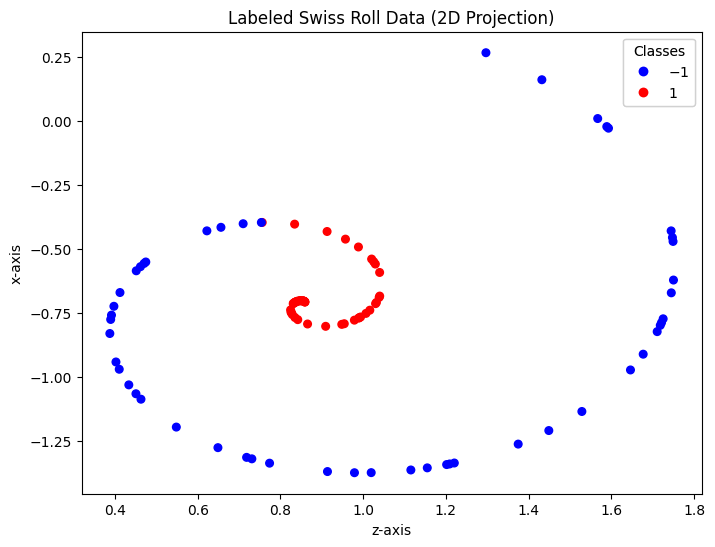

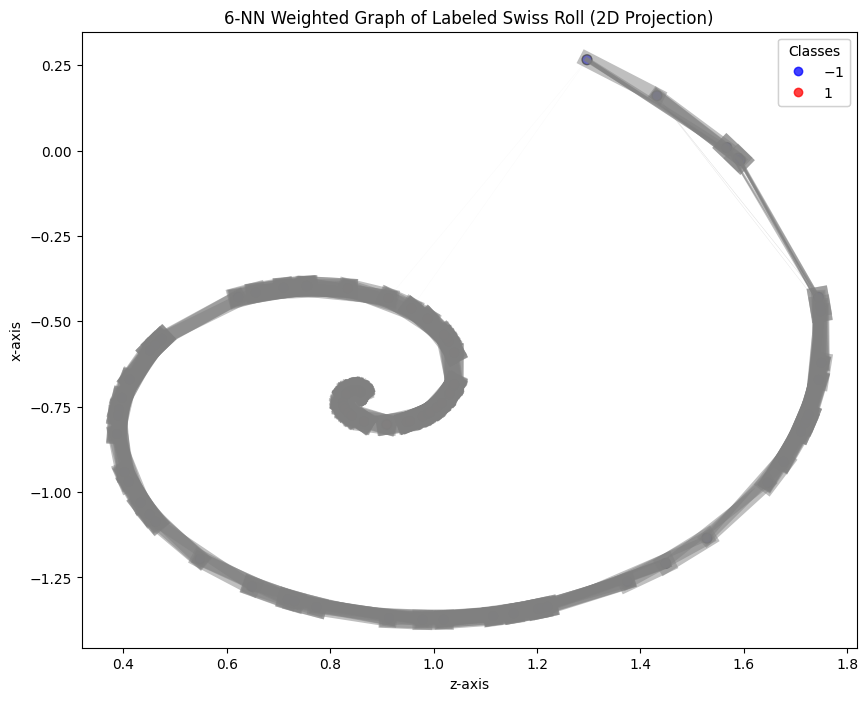

In [29]:
# Cell 10: Generate Labeled Swiss Roll Data and Plot Weighted Graph

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

n_samples_test = n_samples  # Use the same number of samples as training
scale = 10  # Same scale used in training
k = 6        # A chosen k (can be different, but let's keep consistent)
seed_for_visualization = 15

# Generate one randomly transformed Swiss Roll graph with additional outputs for plotting using the same seed
t, a_translated, adj, L_test, target_eigenvals, target_ev = generate_weighted_swiss_roll_graph(
    n_samples=n_samples_test,
    scale=scale,
    k=k,
    seed=seed_for_visualization,
    return_extra=True   # Enable returning additional data for plotting
)

Shape of predicted_embedding: (100, 4)
Shape of actual_embedding: (100, 4)


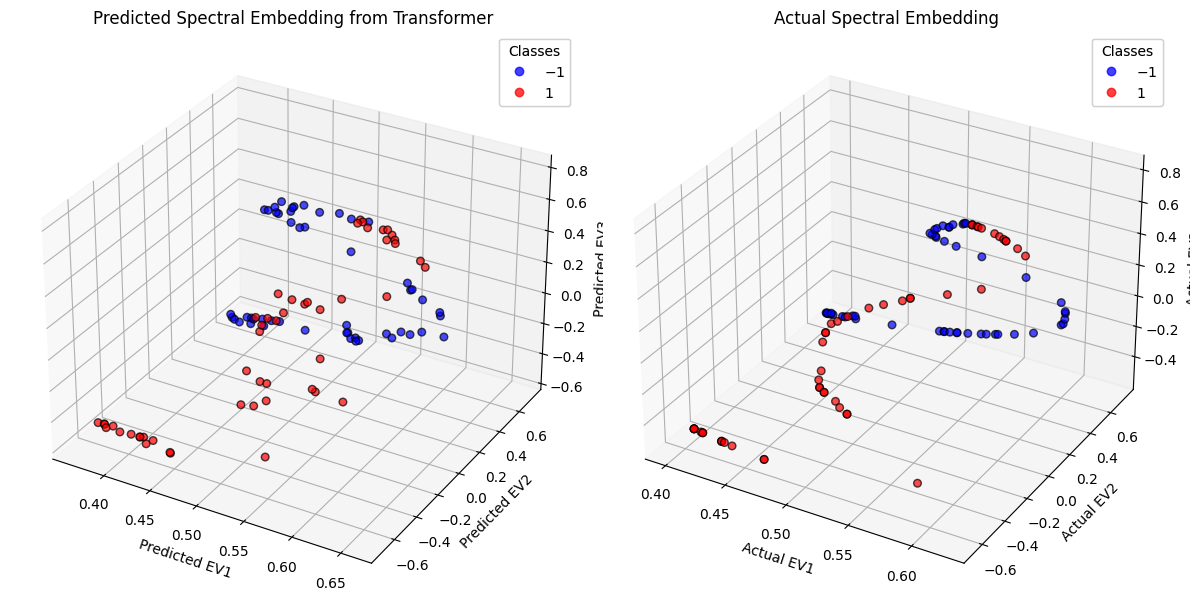

In [30]:
# Cell 11: Compute Embeddings Using Trained Transformer with Weighted Adjacency

import numpy as np
import matplotlib.pyplot as plt
import torch

# Use the same parameters as in Cell 5 and 6
n_samples_test = n_samples
scale = 10
k = 6
seed_for_testing = 15  # same seed to ensure same graph
k_feat = 4  # same as training

# Generate the test Swiss roll graph
adj_test2, L_test2, target_eigenvals2, target_ev2 = generate_weighted_swiss_roll_graph(
    n_samples=n_samples_test,
    scale=scale,
    k=k,
    seed=seed_for_testing,
    return_extra=False
)

# Convert adjacency to incidence
B_test2_cpu, n_edges_test2 = adjacency_to_incidence(adj_test2.cpu(), n_samples_test, n_samples_test*k)
B_test2 = B_test2_cpu.to(device)

# Compute B B^T (laplacian)
# lap_test2 = B_test2 @ B_test2.transpose(0,1)
lap_test2 = L_test2

# Select and normalize eigenvectors
eigenvecs_selected_test2 = target_ev2[:, :k_feat]
eigenvecs_selected_test2 /= (np.linalg.norm(eigenvecs_selected_test2, axis=1, keepdims=True) + 1e-10)

# Construct Z_test for embeddings
Z_test2 = torch.zeros(1, n_samples_test, 2*n_samples_test + k_feat, device=device)
Z_test2[0, :, :n_samples_test] = lap_test2
Z_test2[0, :, n_samples_test:2*n_samples_test] = adj_test2.to(device)
Z_test2[0, :, 2*n_samples_test:] = torch.from_numpy(eigenvecs_selected_test2).float().to(device)

# Pass Z_test2 through the transformer to get embeddings
model.eval()
with torch.no_grad():
    output_test2 = model(Z_test2)  # Shape: [1, n_samples_test, n + (n+k)]
    # Extract predicted eigenvectors
    predicted_ev = output_test2[0, :, -k_feat:].cpu().numpy()  # [n_samples_test, k_feat]

# Compute actual eigenvectors for comparison (as before)
B_tensor_test2 = B_test2.unsqueeze(0)
L_test_normalized = L_test2  # Already computed normalized Laplacian above in gen function

# L_test2 is the normalized Laplacian returned by generate_weighted_swiss_roll_graph,
# which matches what was done in cell 3. Use that directly.
# target_ev2 are the eigenvectors for L_test2

# Assign labels based on t for visualization
# We have 't' from Cell 6 or we can re-generate t using the same seed and n_samples
t_test, data_test = gen_random_data(1, n_samples_test, type='swissroll')
data_test = data_test.to(device)
labels = np.where(t_test.cpu().numpy()[0] < np.median(t_test.cpu().numpy()), 1, -1)

# Actual embeddings (taking EV2, EV3, EV4):
embedding_dims = [0, 1, 2, 3]
actual_embedding = target_ev2[:, embedding_dims]  # [n_samples_test, 3]

# Predicted embedding
predicted_embedding = predicted_ev  # [n_samples_test,4]

actual_embedding = actual_embedding / (np.linalg.norm(actual_embedding, axis=1, keepdims=True) + 1e-10)
predicted_embedding = predicted_ev / (np.linalg.norm(predicted_ev, axis=1, keepdims=True) + 1e-10)

print(f"Shape of predicted_embedding: {predicted_embedding.shape}")
print(f"Shape of actual_embedding: {actual_embedding.shape}")

# Plot the predicted and actual embeddings
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
scatter = ax.scatter(predicted_embedding[:, 0], predicted_embedding[:, 1], predicted_embedding[:, 2],
                     c=labels, cmap=plt.cm.bwr, s=30, edgecolor='k', alpha=0.7)
ax.set_xlabel('Predicted EV1')
ax.set_ylabel('Predicted EV2')
ax.set_zlabel('Predicted EV3')
ax.set_title('Predicted Spectral Embedding from Transformer')
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

ax = fig.add_subplot(122, projection='3d')
scatter = ax.scatter(actual_embedding[:, 0], actual_embedding[:, 1], actual_embedding[:, 2], 
                     c=labels, cmap=plt.cm.bwr, s=30, edgecolor='k', alpha=0.7)
ax.set_xlabel('Actual EV1')
ax.set_ylabel('Actual EV2')
ax.set_zlabel('Actual EV3')
ax.set_title('Actual Spectral Embedding')
legend2 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend2)

plt.tight_layout()
plt.show()


In [31]:
# Cell 12: Train Logistic Regression from Scratch (PyTorch) With and Without Embedding, and RKHS Classifier
# Compare to ICL Transformer and End-to-end Transformer

import torch
import torch.nn as nn
import numpy as np  # Ensure numpy is imported

# We assume predicted_embedding, actual_embedding, labels, and data_test are all defined from Cell 7.
# predicted_embedding: [100,4]
# actual_embedding: [100,n_samples_test]
# labels: shape [100], values in {1, -1}
# data_test: [1, 100, 2]

X_features = data_test.cpu().numpy().reshape(n_samples_test, 2)  # [100, 2]
X_model_embed = predicted_embedding[:, :4]  # [100, 4]
X_actual_embed = actual_embedding  # [100, 4]

X_features_t = torch.tensor(X_features, dtype=torch.float32)
X_model_embed_t = torch.tensor(X_model_embed, dtype=torch.float32)
X_actual_embed_t = torch.tensor(X_actual_embed, dtype=torch.float32)

labels_t = torch.tensor(labels, dtype=torch.float32)
labels_binary = (labels_t == 1.0).float()  # Convert to {0,1}

# load icl models
icl_model_pe = InContextClassifier(n_layers=2, n_categories=2, kernel='linear', pe_dim=4).to(device)
icl_model_pe.load_state_dict(torch.load("icl_tf_linear_pred_pe_c_99.pth", weights_only=True))

icl_model_exact = InContextClassifier(n_layers=2, n_categories=2, kernel='linear', pe_dim=4).to(device)
icl_model_exact.load_state_dict(torch.load("icl_tf_linear_exact_pe_c_99.pth", weights_only=True))

def train_logistic_regression(X_train, y_train, X_test, y_test, epochs=1000, lr=0.1):
    model = nn.Linear(X_train.shape[1], 1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for _ in range(epochs):
        optimizer.zero_grad()
        logits = model(X_train)
        loss = criterion(logits.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        logits_test = model(X_test)
        probs = torch.sigmoid(logits_test.squeeze())
        preds = (probs > 0.5).float()
        acc = (preds == y_test).float().mean().item()
    return acc

def rbf_kernel(X, Y, gamma=1.0):
    diff = X.unsqueeze(1) - Y.unsqueeze(0)
    sqdist = (diff**2).sum(dim=2)
    return torch.exp(-gamma * sqdist)
    
def train_rkhs_classifier(X_train, y_train, X_test, y_test, gamma=1.0, epochs=1000, lr=0.1):
    N = X_train.shape[0]
    # Initialize gamma as a learnable parameter
    gamma_param = torch.tensor(gamma, requires_grad=True)
    alpha = torch.zeros(N, 1, requires_grad=True)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD([alpha, gamma_param], lr=lr)
    
    for _ in range(epochs):
        optimizer.zero_grad()
        # Compute kernel with current gamma
        K_train = rbf_kernel(X_train, X_train, gamma=gamma_param)
        logits = K_train @ alpha
        loss = criterion(logits.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        # Ensure gamma stays positive
        gamma_param.data.clamp_(min=1e-4)

    with torch.no_grad():
        K_test = rbf_kernel(X_test, X_train, gamma=gamma_param)
        logits_test = K_test @ alpha
        probs = torch.sigmoid(logits_test.squeeze())
        preds = (probs > 0.5).float()
        acc = (preds == y_test).float().mean().item()
    return acc

percents = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 41, 44, 47, 50]
averages_no_embed = []
averages_with_model_embed = []
averages_with_actual_embed = []
averages_rkhs = []
averages_icl_model_embed = []
averages_icl_actual_embed = []
averages_endtoend_default = []

num_runs = 25

for percent in percents:
    acc_no_embed_runs = []
    acc_model_embed_runs = []
    acc_actual_embed_runs = []
    acc_rkhs_runs = []
    acc_icl_model_embed_runs = []
    acc_icl_actual_embed_runs = []
    acc_endtoend_default_runs = []

    n_labeled = int(n_samples_test * percent / 100)
    for _ in range(num_runs):
        indices = np.arange(n_samples_test)
        np.random.shuffle(indices)
        labeled_indices = indices[:n_labeled]
        unlabeled_indices = indices[n_labeled:]

        X_train_no_embed = X_features_t[labeled_indices]
        y_train = labels_binary[labeled_indices]
        X_test_no_embed = X_features_t[unlabeled_indices]
        y_test = labels_binary[unlabeled_indices]

        X_train_model_embed = X_model_embed_t[labeled_indices]
        X_test_model_embed = X_model_embed_t[unlabeled_indices]

        X_train_actual_embed = X_actual_embed_t[labeled_indices]
        X_test_actual_embed = X_actual_embed_t[unlabeled_indices]
        
        # # Train logistic regression without embedding
        # acc_no_embed = train_logistic_regression(X_train_no_embed, y_train, X_test_no_embed, y_test)
        # acc_no_embed_runs.append(acc_no_embed)

        # # Train logistic regression with transformer's embedding
        # acc_model_embed = train_logistic_regression(X_train_model_embed, y_train, X_test_model_embed, y_test)
        # acc_model_embed_runs.append(acc_model_embed)

        # # Train logistic regression with actual spectral embedding
        # acc_actual_embed = train_logistic_regression(X_train_actual_embed, y_train, X_test_actual_embed, y_test)
        # acc_actual_embed_runs.append(acc_actual_embed)

        # # Train RKHS classifier (Kernel Logistic Regression) on non-embedded data
        # acc_rkhs = train_rkhs_classifier(X_train_no_embed, y_train, X_test_no_embed, y_test, gamma=1.0, epochs=500, lr=0.05)
        # acc_rkhs_runs.append(acc_rkhs)

        # ICL Transformer trained on PE Transformer embedding
        icl_model_pe.eval()
        with torch.no_grad():
            _, _, icl_pe_query_loss, icl_pe_query_accuracy, _ = icl_model_pe.train_step(X_model_embed_t.unsqueeze(0), 
                                                                                        labels_binary.unsqueeze(0), 
                                                                                        torch.from_numpy(labeled_indices).unsqueeze(0), 
                                                                                        torch.from_numpy(unlabeled_indices).unsqueeze(0))
        acc_icl_model_embed_runs.append(icl_pe_query_accuracy.item())

        # ICL Transformer trained on exact embedding
        icl_model_exact.eval()
        with torch.no_grad():
            _, _, icl_actual_query_loss, icl_actual_query_accuracy, _ = icl_model_exact.train_step(X_actual_embed_t.unsqueeze(0), 
                                                                                                    labels_binary.unsqueeze(0), 
                                                                                                    torch.from_numpy(labeled_indices).unsqueeze(0), 
                                                                                                    torch.from_numpy(unlabeled_indices).unsqueeze(0))
        acc_icl_actual_embed_runs.append(icl_actual_query_accuracy.item())

        # End-to-end Transformer with default initializations
        joint_model_default.eval()
        with torch.no_grad():
            _, _, _, joint_default_query_acc, _ = joint_model_default.train_step(Z_test2, 
                                                                                labels_binary.unsqueeze(0), 
                                                                                torch.from_numpy(labeled_indices).unsqueeze(0), 
                                                                                torch.from_numpy(unlabeled_indices).unsqueeze(0))
        acc_endtoend_default_runs.append(joint_default_query_acc.item())

    # avg_no_embed = np.mean(acc_no_embed_runs)
    # avg_model_embed = np.mean(acc_model_embed_runs)
    # avg_actual_embed = np.mean(acc_actual_embed_runs)
    # avg_rkhs = np.mean(acc_rkhs_runs)
    avg_icl_model_embed = np.mean(acc_icl_model_embed_runs)
    avg_icl_actual_embed = np.mean(acc_icl_actual_embed_runs)
    avg_endtoend_default = np.mean(acc_endtoend_default_runs)

    # averages_no_embed.append(avg_no_embed)
    # averages_with_model_embed.append(avg_model_embed)
    # averages_with_actual_embed.append(avg_actual_embed)
    # averages_rkhs.append(avg_rkhs)
    averages_icl_model_embed.append(avg_icl_model_embed)
    averages_icl_actual_embed.append(avg_icl_actual_embed)
    averages_endtoend_default.append(avg_endtoend_default)

    print(f"Percent labeled: {percent}%")
    # print(f"  Accuracy without embedding (avg of {num_runs} runs): {avg_no_embed:.4f}")
    # print(f"  Accuracy with transformer's embedding (avg of {num_runs} runs): {avg_model_embed:.4f}")
    # print(f"  Accuracy with actual spectral embedding (avg of {num_runs} runs): {avg_actual_embed:.4f}")
    # print(f"  Accuracy with RKHS classifier (avg of {num_runs} runs): {avg_rkhs:.4f}")
    print(f"  Accuracy with ICL with transformer's embedding (avg of {num_runs} runs): {avg_icl_model_embed:.4f}")
    print(f"  Accuracy with ICL with actual embedding (avg of {num_runs} runs): {avg_icl_actual_embed:.4f}")
    print(f"  Accuracy with End-to-end Transformer with default initialization (avg of {num_runs} runs): {avg_endtoend_default:.4f}\n")

Percent labeled: 3%
  Accuracy with ICL with transformer's embedding (avg of 25 runs): 0.8165
  Accuracy with ICL with actual embedding (avg of 25 runs): 0.7633
  Accuracy with End-to-end Transformer with default initialization (avg of 25 runs): 0.8033

Percent labeled: 6%
  Accuracy with ICL with transformer's embedding (avg of 25 runs): 0.8498
  Accuracy with ICL with actual embedding (avg of 25 runs): 0.8230
  Accuracy with End-to-end Transformer with default initialization (avg of 25 runs): 0.8328

Percent labeled: 9%
  Accuracy with ICL with transformer's embedding (avg of 25 runs): 0.8659
  Accuracy with ICL with actual embedding (avg of 25 runs): 0.8501
  Accuracy with End-to-end Transformer with default initialization (avg of 25 runs): 0.8598

Percent labeled: 12%
  Accuracy with ICL with transformer's embedding (avg of 25 runs): 0.9227
  Accuracy with ICL with actual embedding (avg of 25 runs): 0.8932
  Accuracy with End-to-end Transformer with default initialization (avg of 2

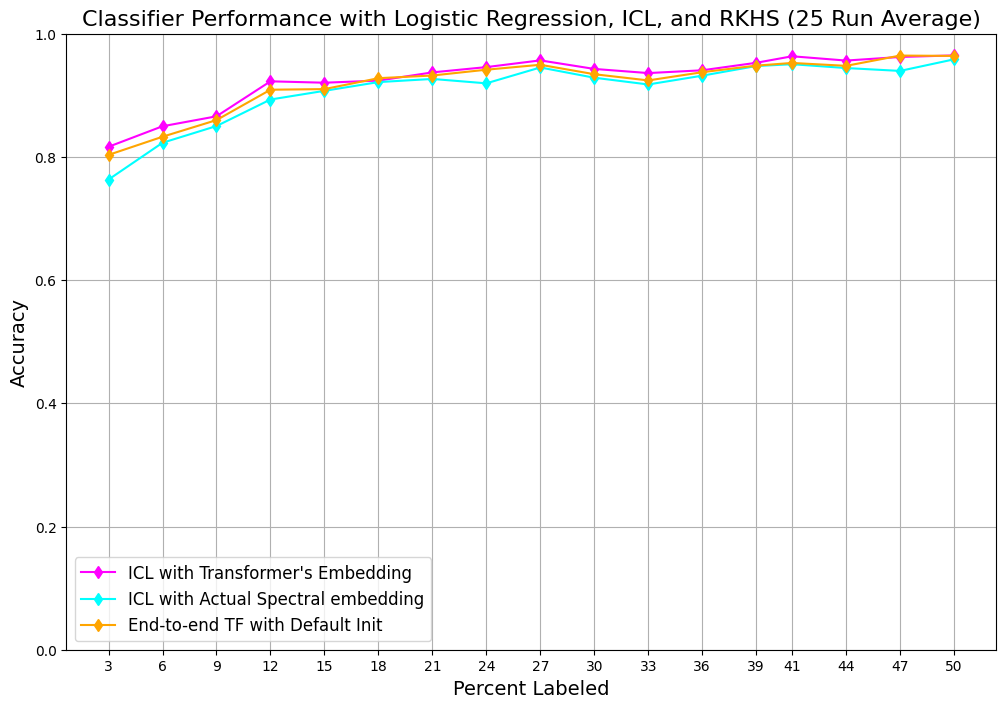

In [32]:
# Cell 13: Plot Classifier Performance (Updated for Averaged Accuracies Including RKHS Classifier, ICL Transformer, End-to-End Transformer)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plotting the averaged accuracies
# plt.plot(percents, averages_no_embed, label='Logistic Regression Without Embedding', marker='o', color='blue')
# plt.plot(percents, averages_with_model_embed, label='Logistic Regression With Transformer\'s Embedding', marker='s', color='green')
# plt.plot(percents, averages_with_actual_embed, label='Logistic Regression With Actual Spectral Embedding', marker='^', color='red')
# plt.plot(percents, averages_rkhs, label='RKHS Classifier', marker='d', color='purple')  # Added RKHS classifier
plt.plot(percents, averages_icl_model_embed, label='ICL with Transformer\'s Embedding', marker='d', color='magenta')  # Added ICL transformer
plt.plot(percents, averages_icl_actual_embed, label='ICL with Actual Spectral embedding', marker='d', color='cyan')  # Added ICL transformer
plt.plot(percents, averages_endtoend_default, label='End-to-end TF with Default Init', marker='d', color='orange')  # Added end-to-end transformer

# Setting labels and title
plt.xlabel('Percent Labeled', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Classifier Performance with Logistic Regression, ICL, and RKHS (25 Run Average)', fontsize=16)

# Adding legend and grid
plt.legend(fontsize=12)
plt.grid(True)

# Setting x-axis ticks and y-axis limits
plt.xticks(percents)
plt.ylim(0, 1)

plt.savefig('endtoend_default.jpg')

# Display the plot
plt.show()